## Check_spinup global results
- reads in MIMICS results and checks for change in soil and veg C pool & fluxes
- data are here /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS/OUTPUT_CN/SPIN

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy 
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

print(xr.__version__)
%matplotlib inline

0.15.0


In [2]:
import pandas.util.testing as tm
path = '/project/tss/wwieder/biogeochem_testbed_1.1/'
case = 'GRID_CN/MIMICS/OUTPUT_CN/SPIN/'
full_pathMIM = path+case+'mimics_pool_flux_*0.nc'  # read in data every 10 years
full_pathCAS = path+case+'casaclm_pool_flux_*0.nc' # casa files for vegetation results
print(full_pathMIM)

ds   = xr.open_mfdataset(full_pathMIM, decode_times=True, combine='by_coords')
dsVeg= xr.open_mfdataset(full_pathCAS, decode_times=True, combine='by_coords')

#combine relevent data from casa history files to MIMICS data
ds['cnpp'] = dsVeg['cnpp']
ds['cgpp'] = dsVeg['cgpp']

# sum soil C & N pools
ds = utils.sum_pools(ds, 'mim')
print('-- read in dataset -- ')

/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS/OUTPUT_CN/SPIN/mimics_pool_flux_*0.nc


/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """Entry point for launching an IPython kernel.


-- read in dataset -- 


## Define function for global sum & spatial plots

In [3]:
def globalSum ( dsIn, var, area=ds.landarea.isel(time=-1) *1e6, time=1, conversion=1e-15, units=None, plot=True ):
    "Global weighted sum of fluxes & states"
    temp = dsIn[var] * area 
    temp = temp.sum(dim=('lat','lon')) * conversion
    if plot==True:
        plt.figure(figsize=[20,6]);
        for i in range(len(var)):
            plt.subplot(1, 3, (1+i))
            plt.ylabel('Global '+var[i]+' (Pg C y^-1)')
            plt.plot(temp['time'], temp[var[i]]);

    else:
        for i in range(len(var)):
            print('global '+var[i]+' '+str(np.round(temp[var[i]].isel(time=-1).values,1) )+' Pg C')

In [4]:
# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,-65,80], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.95), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:
        fig.colorbar(im, ax=ax,shrink=0.40, pad=0, fraction = 0.1)

# strings for labeling panels
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']  

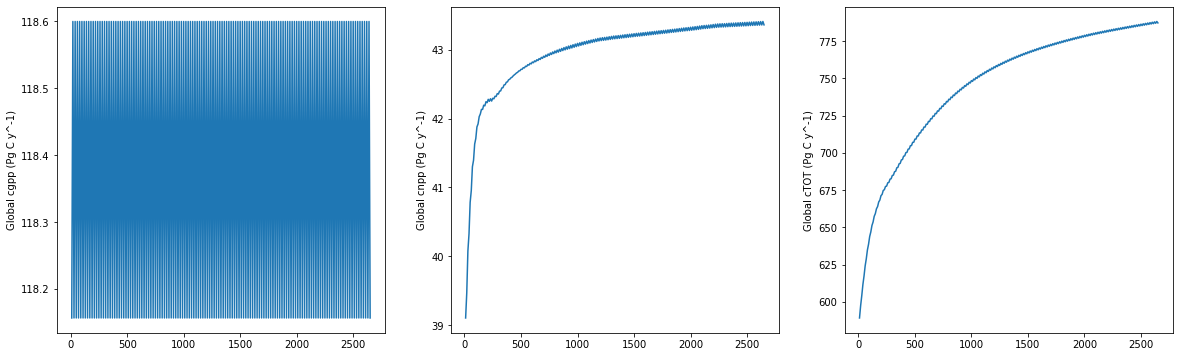

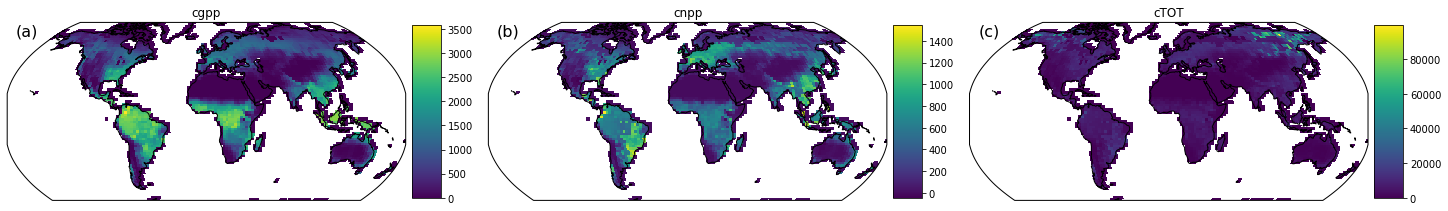

In [5]:
Cvars =['cgpp','cnpp','cTOT']
globalSum(ds,Cvars, plot=True)

# Now call the map_function
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = ds[Cvars[index[0]]].isel(time=-1)
    map_function(da, panel=panel[i], ax=ax, title=Cvars[index[0]], cb=1)

### total soil C:N

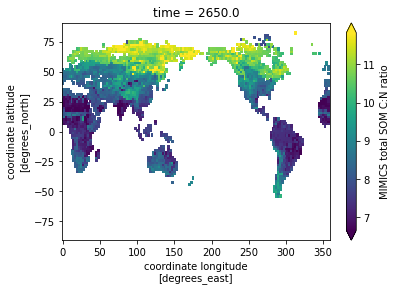

In [6]:
ds['cnTOT'].isel(time=-1).plot(robust=True);

## Look at MIMCS_Conly & CASAcn

In [7]:
ConlyIN = '/project/tss/wwieder/CASACLM/GRID/OUTPUT_GRID_CRU_NCEP/MIMICS_SPIN_b/'
Ccas = ConlyIN+'casaclm_pool_flux_9000_9980.nc'
Cmim = ConlyIN+'mimics_pool_flux_9000_9980.nc'

CNcas = '/project/tss/bgc01/melannie/git_CASACLM/biogeochem_testbed_1.1/GRID_CN/CASACNP/OUTPUT_CN/SPIN/'
CNcas = CNcas + 'casaclm_pool_flux_99?0.nc'
CNcas

'/project/tss/bgc01/melannie/git_CASACLM/biogeochem_testbed_1.1/GRID_CN/CASACNP/OUTPUT_CN/SPIN/casaclm_pool_flux_99?0.nc'

In [9]:
dsCmim   = xr.open_mfdataset(Cmim, decode_times=True,combine='by_coords')
dsCveg   = xr.open_mfdataset(Ccas, decode_times=True,combine='by_coords')
dsCNcas  = xr.open_mfdataset(CNcas, decode_times=True,combine='by_coords')
dsCmim['cnpp'] = dsCveg['cnpp']
dsCmim['cgpp'] = dsCveg['cgpp']
dsCmim  = utils.sum_pools(dsCmim, mod='mim', CN='False')
dsCNcas = utils.sum_pools(dsCNcas, mod='cas', CN='True')

In [10]:
# MIMICS_Conly results
print('MIMICS_C only')
Cvars =['cgpp','cnpp','cTOT']
globalSum(dsCmim,Cvars, plot=False)

# CASA_CN results
print('')
print('CASA-CN results')
globalSum(dsCNcas,Cvars, plot=False)

# MIMICS_CN results
print('')
print('MIMICS-CN results')
globalSum(ds,Cvars, plot=False)

MIMICS_C only
global cgpp 118.6 Pg C
global cnpp 48.9 Pg C
global cTOT 1470.3 Pg C

CASA-CN results
global cgpp 118.2 Pg C
global cnpp 36.4 Pg C
global cTOT 737.0 Pg C

MIMICS-CN results
global cgpp 118.2 Pg C
global cnpp 43.4 Pg C
global cTOT 787.3 Pg C


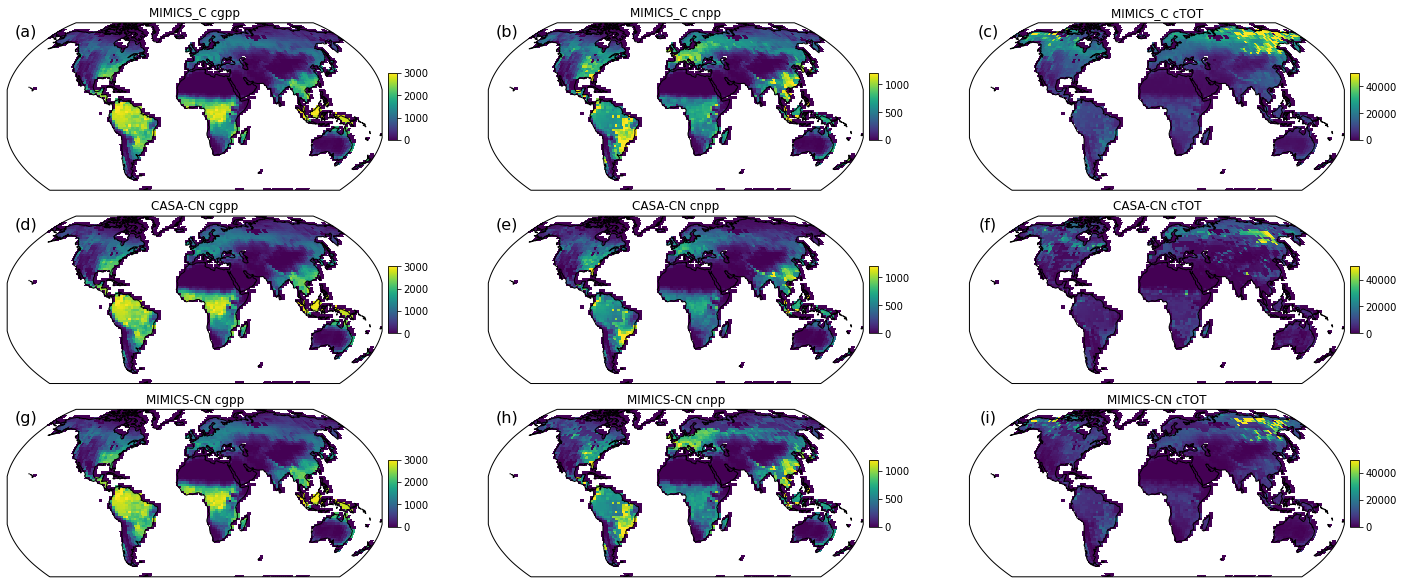

In [11]:
# Call the map_function
sims = ['MIMICS_C ','CASA-CN ','MIMICS-CN ']
Cvars =['cgpp','cnpp','cTOT']
vmax = [3000  ,1200  ,5e4]  #max values for each variable

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    i = index[0]
    j = index[1]
    k = k+1
    if i == 0: da = dsCmim[Cvars[j]].isel(time=-1)
    if i == 1: da = dsCNcas[Cvars[j]].isel(time=-1)
    if i == 2: da = ds[Cvars[j]].isel(time=-1)

    map_function(da, panel=panel[k], ax=ax, vmax=vmax[j], vmin=0, title=sims[i]+Cvars[j], cb=1)

## Difference in NPP (CN-C)
- most notably in boreal forests.
- somewhat int tropcs

In [15]:
ds['d_cnpp'] = (ds['cnpp'].isel(time=-1) - dsCmim['cnpp'].isel(time=-1))/ dsCmim['cnpp'].isel(time=-1) * 100
ds['d_cnpp'].attrs['long_name'] = 'MIMICS % NPP difference from Conly'

ds['d_cTOT'] = ds['cTOT'].isel(time=-1) - dsCmim['cTOT'].isel(time=-1)
ds['d_cTOT'].attrs['long_name'] = 'MIMICS total SOC difference from Conly'

dsCNcas['d_cnpp'] = (dsCNcas['cnpp'].isel(time=-1) - dsCmim['cnpp'].isel(time=-1))/ dsCmim['cnpp'].isel(time=-1) * 100
dsCNcas['d_cnpp'].attrs['long_name'] = 'CASAcn % NPP difference from MIMICS Conly'

dsCNcas['d_cTOT'] = dsCNcas['cTOT'].isel(time=-1) - dsCmim['cTOT'].isel(time=-1)
dsCNcas['d_cTOT'].attrs['long_name'] = 'CASAcn total SOC difference from MIMICS Conly'

Cvars = ['d_cnpp','d_cTOT']

### Call the map_function for: 
- MIMICScn - MIMICS_Conly
- CASAcn - MIMICS_Conly

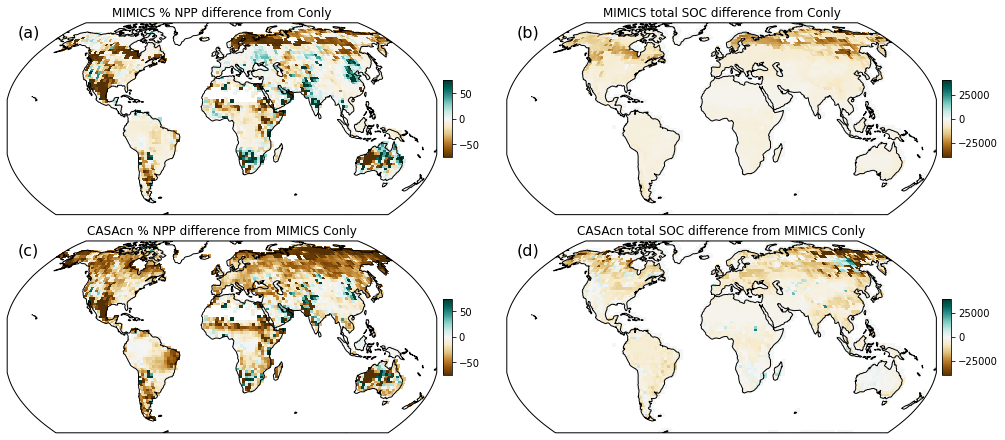

In [16]:
Cvars = ['d_cnpp','d_cTOT']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    i = index[0]
    j = index[1]
    k = k+1
    if i == 0 : 
        da = ds[Cvars[j]]
    else:  
        da = dsCNcas[Cvars[j]]

    if j==0:
        map_function(da, panel=panel[k], ax=ax, title=da.attrs['long_name'], cb=1,cmap='BrBG', vmax=75, vmin=-75)
    else:
        map_function(da, panel=panel[k], ax=ax, title=da.attrs['long_name'], cb=1,cmap='BrBG', vmax=4e4, vmin=-4e4)
    

## Look at zonal mean plots for lat. bands

In [20]:
var  =  ['cnpp', 'cgpp','cTOT']
varLong  =  ['npp', 'gpp','total soil C']

# sum up fluxes
ann_fluxCmim = dsCmim * dsCmim.landarea *1e6
ann_fluxCNcas = dsCNcas * dsCNcas.landarea *1e6
ann_fluxCNmim = ds * ds.landarea *1e6
for i in range(len(var)):
    ann_fluxCmim.get(var[i]).attrs['units'] = 'gC y-1'    
    ann_fluxCNcas.get(var[i]).attrs['units'] = 'gC y-1'
    ann_fluxCNmim.get(var[i]).attrs['units'] = 'gC y-1'


In [21]:
zon_sumCmim = ann_fluxCmim.sum(dim='lon') *1e-15
zon_sumCNcas = ann_fluxCNcas.sum(dim='lon') *1e-15
zon_sumCNmim = ann_fluxCNmim.sum(dim='lon') *1e-15


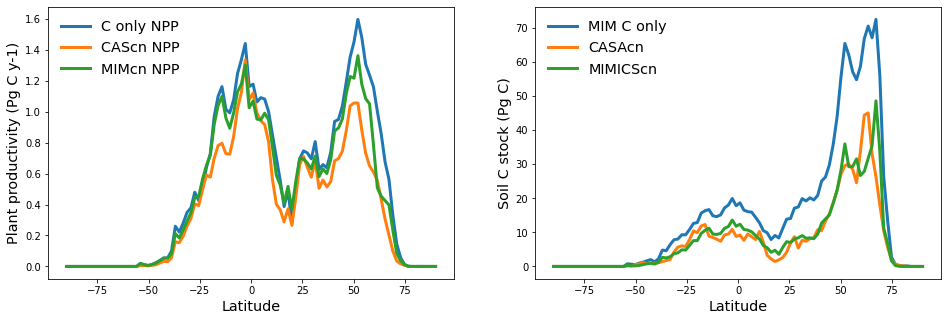

In [22]:
plt.figure(figsize=[16,5])
plt.subplot(121)

#plt.ylabel('Change Global Land C ('+g585y.units+')', fontsize='x-large')
plt.plot(zon_sumCmim.lat, zon_sumCmim.get('cnpp').isel(time=-1), lw=3)
plt.plot(zon_sumCNcas.lat, zon_sumCNcas.get('cnpp').isel(time=-1), lw=3)
plt.plot(zon_sumCNmim.lat, zon_sumCNmim.get('cnpp').isel(time=-1), lw=3)
#plt.plot(zon_sumCNmim.lat, zon_sumCNmim.get('cgpp').isel(time=-1), lw=3)

plt.legend(labels=['C only NPP','CAScn NPP','MIMcn NPP'], frameon = False, fontsize='x-large')
plt.ylabel('Plant productivity (Pg C y-1)', fontsize='x-large')
plt.xlabel('Latitude', fontsize='x-large');

plt.subplot(122)
plt.plot(zon_sumCmim.lat, zon_sumCmim.get('cTOT').isel(time=-1), lw=3)
plt.plot(zon_sumCNcas.lat, zon_sumCNcas.get('cTOT').isel(time=-1), lw=3)
plt.plot(zon_sumCNmim.lat, zon_sumCNmim.get('cTOT').isel(time=-1), lw=3)
plt.legend(labels=['MIM C only','CASAcn','MIMICScn'], frameon = False, fontsize='x-large')
plt.ylabel('Soil C stock (Pg C)', fontsize='x-large')
plt.xlabel('Latitude', fontsize='x-large');

